In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import pyrosm as py
import ast

import haversine as hs
import requests
import json
import googlemaps
from datetime import datetime

from API import K

In [ ]:
## Import data

In [32]:
from io import StringIO
from flask import Flask, send_file
import numpy as np
from skimage.io import imsave
import matplotlib.pyplot as plt

In [3]:
df_pr=pd.read_excel('Data/P_R_Datenbank_2019_ohne.xlsx')

In [4]:
df_pr['P+R']=True
df_pr.Day_price.replace('','free',inplace=True)


In [37]:
os.path
# full_filename = os.listdir('Documents/GitHub/Parking_Munich/A_fig.jpg')

<module 'ntpath' from 'C:\\Users\\Fabia\\anaconda3\\envs\\gds\\lib\\ntpath.py'>

## Create a random point
Random point somewhere in Munich, that might be a destination, to use to test function

In [5]:
#random point somewhere in Munich to tryout script
import random

latlon_r=(random.uniform(48.248116, 48.061624),random.uniform(11.722910, 11.360777))
print("Random point was selected", (latlon_r))

Random point was selected (48.124490882797616, 11.37148850633771)


In [14]:
def find_nearest_parking(latlon, df=df_pr, expected_arrival=datetime.now()):
    """Function to find the nearest parkingplace in Munich given a latitude, 
    longtitude or address and a dataframe with parkings that contains for each entry \
    at least a lon and lat column and optionally an expected arrival time."""
    if type(latlon) is tuple:
        lat_r=latlon[0]
        lon_r=latlon[1]
    else:
        r= requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={'Marienplatz 1,Munich,Germany'}&key={K}")
        #unpack
        results = json.loads(r.content)
        lat_r=results['results'][0]['geometry']['location']['lat']
        lon_r=results['results'][0]['geometry']['location']['lng']
    
    #create new columns to fill later
    df['bird_dist'] = 0
    
    df['est_time_walking'] = 0
    df['est_time_bicycling'] = 0
    df['est_time_transit'] = 0
    
    df['est_dist_walking'] = 0
    df['est_dist_bicycling'] = 0
    df['est_dist_transit'] = 0
    
    #combine lat and lon in one column
    df['lat_lon']=list(zip(df.lat, df.lon))
    
    #calculate distance as the crow flies from dest to all parkings
    df['bird_dist'] = df.lat_lon.apply(lambda p: hs.haversine((lat_r,lon_r),p))
    
    #sort values based on bird_dist, reset index
    df.sort_values(by='bird_dist',inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    #calculate travel times to final dest for 5 parkings that are the nearest as the crow flies and add them to df
    for i in range (5):
        for j in ['walking','bicycling','transit']:
            #run google api and unpack relevant variables
            if type(latlon) is tuple:
                r = requests.get(f"https://maps.googleapis.com/maps/api/directions/json?origin={df.lat[i]},{df.lon[i]}&destination={latlon[0]},{latlon[1]}&mode={j}&key={K}")
            else:
                r = requests.get(f"https://maps.googleapis.com/maps/api/directions/json?origin={df.lat[i]},{df.lon[i]}&destination={latlon}&mode={j}&key={K}")
            #unpack
            results = json.loads(r.content)
            legs = results.get("routes").pop(0).get("legs")
            dur_dist=(legs[0].get("duration"), legs[0].get("distance"))
            #save data in previously assigned columns
            df['est_time_'+str(j)][i] = dur_dist[0]['text']
            df['est_dist_'+str(j)][i] = dur_dist[1]['text']
    
    #only first 5 are interesting, drop irrelevant columns
    df=df[:5].drop(columns=['Bahnhof','BahnhofID','GlobaleID', 'Name','Niveau,N,10,0','bird_dist','P+R','MVTT_x','MVTT_y', "Georeferenz", "Name DIVA", "lat_lon"])
    df.rename(columns={"Alternative_name": "Name"}, inplace=True)
    
    #subset availability
    availability = df.filter(regex='OCC_')
    availability = availability.join(df.loc[:,'Name'], lsuffix='_caller', rsuffix='_other')
    availability.set_index('Name', drop=True, inplace=True)
    
    #remove from other dataframe
    df.drop(list(df.filter(regex = 'OCC_')), axis = 1, inplace = True)
    return(df, availability)

In [15]:
results=find_nearest_parking('Marienplatz1, Munich, Germany')

C:\Users\Fabia\anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Fabia\anaconda3\envs\gds\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Fabia\anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
df1=results[0]
df2=results[1]

In [17]:
df1

,Name,lon,lat,Capacity,P_women,P_family,P_invalid,Entrance,Day_price,Ticket_for_10,Month_ticket,Year_ticket,Link,est_time_walking,est_time_bicycling,est_time_transit,est_dist_walking,est_dist_bicycling,est_dist_transit
0,P+R Heimeranplatz,11.532054,48.131103,310,31.0,NaN,3,Lift,1.5,14.5,19,190,https://www.mvv-muenchen.de/plaene-bahnhoefe/b...,48 mins,16 mins,17 mins,3.8 km,4.3 km,5.3 km
1,P+R Innsbrucker Ring,11.618515,48.120732,95,NaN,NaN,1,Lift,1.5,14.5,19,190,https://www.mvv-muenchen.de/plaene-bahnhoefe/b...,50 mins,18 mins,10 mins,4.0 km,5.3 km,5.6 km
2,P+R Mangfallplatz,11.574731,48.095810,255,24.0,NaN,7,Lift,1.5,14.5,19,190,https://www.mvv-muenchen.de/plaene-bahnhoefe/b...,1 hour 7 mins,22 mins,17 mins,5.4 km,6.7 km,6.5 km
3,P+R Michaelibad,11.631955,48.119178,277,NaN,NaN,NaN,(Roll-)Treppe,1.5,14.5,19,190,https://www.mvv-muenchen.de/plaene-bahnhoefe/b...,1 hour 6 mins,22 mins,14 mins,5.2 km,6.2 km,6.3 km
4,P+R Olympiazentrum,11.554203,48.180049,274,NaN,NaN,3,Lift,1.5,14.5,19,190,https://www.mvv-muenchen.de/plaene-bahnhoefe/b...,1 hour 16 mins,25 mins,13 mins,6.0 km,6.6 km,6.5 km


In [ ]:
#Want to plot the occupancy
a=results[1]

#Delete parkings of which we don't have the occupancy
a.dropna(how="all", axis=1, inplace=True)

#Give columns plottable name
a.columns=list(np.arange(5,23,1))

#setup grid
fig,ax=plt.subplots(1,1,dpi=100, figsize=(8,5))
tcks=[]
locs=[]
for i in range(5,23,3):
    tcks.append(str(i)+"h")
    locs.append(i)
plt.xticks(locs, tcks)

#plot vertical line at current time if 
if 5<datetime.now().hour<22:
    plt.axvline(x=(datetime.now().hour+(datetime.now().minute/60)), linestyle="--", alpha=0.5, color='r', label='Current_time')
ax.set_xlabel('Time of day')
ax.set_ylabel('Expected occupancy [%]')
ax.set_title('Expected occupancy during the day')

for i,j in enumerate(a.index):
    print()
    ax=a.iloc[i].plot(alpha=0.5)

# legend = plt.legend(loc="lower left", edgecolor="black", fontsize=8, framealpha=0)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True, ncol=5)

In [21]:
# as a function
def vis_occ(df1):
    a=results[1]

    #Delete parkings of which we don't have the occupancy
    a.dropna(how="all", axis=1, inplace=True)

    #Give columns plottable name
    a.columns=list(np.arange(5,23,1))

    #setup grid
    fig,ax=plt.subplots(1,1,dpi=100, figsize=(8,5))
    tcks=[]
    locs=[]
    for i in range(5,23,3):
        tcks.append(str(i)+"h")
        locs.append(i)
    plt.xticks(locs, tcks)

    #plot vertical line at current time if 
    if 5<datetime.now().hour<22:
        plt.axvline(x=(datetime.now().hour+(datetime.now().minute/60)), linestyle="--", alpha=0.5, color='r', label='Current_time')
    ax.set_xlabel('Time of day')
    ax.set_ylabel('Expected occupancy [%]')
    ax.set_title('Expected occupancy during the day')

    for i,j in enumerate(a.index):
        print()
        ax=a.iloc[i].plot(alpha=0.5)

    # legend = plt.legend(loc="lower left", edgecolor="black", fontsize=8, framealpha=0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True, ncol=5)
    return(fig)

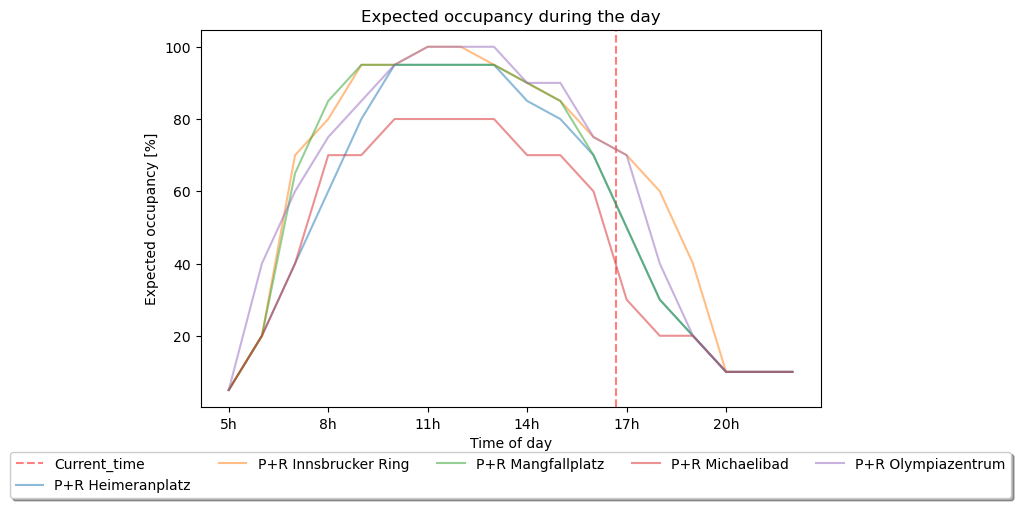

In [23]:
a=vis_occ(results[1])

## Lookup other potential data suppliers

In [ ]:
df_11=pd.read_excel('Data/Parkings_in_and_near.xlsx')

In [ ]:
for i in df_11.columns:
    print(i, df_11[i].count(), df_11[i].nunique())

In [ ]:
df_11.operator.unique()

In [ ]:
df_12=df_11.copy()
df_12.dropna(subset=['operator'],inplace=True)
df_12.drop(columns=['tags'],inplace=True)
df_12[df_12['operator'].str.contains("Contipark")].dropna(how='all',axis=1).operator

In [ ]:
df_12[df_12['operator'].str.contains("Contipark")].dropna(how='all',axis=1)